# QC of Genetics Portal Evidence

## Findings

1. There are 75 studies in the 21.11 dataset which used to have efo identifiers, but they don't have anymore. Two of these are GCST identifiers, probably the implicated studies the genetics team already knows about. Rest of the list are FINNGEN and UKBB studies, with weird trait categories. This discrepancy leads to dropping 8k evidence. 
    * Verify the reasoning behind the mappings.
    * Was it only the ambiguity of the mapping? Or the nature of the studied trait? 
2. In the unfiltered evidence set (l2g threshold == 0), there are 627,835 evidence from 18,031 studies. When applying the l2g >= 0.05 cutoff, the number of studies dropped to 17,359. So because of the l2g threshold, we are losing only 672 studies.
3. When compared to the Genetics Portal evidence set from the 21.09 release, I have found due to missing studies, only 147 evidence from 26 studies were lost. These 26 studies are missing from the unfiltered dataset. When the l2g threshold is applied the number of missing studies were 178 with 1788 evidence.
4. However, when looking at the disease/study/target/variant set, the overlap is poorer. 65k of the old evidence set could not be found in the new dataset completely, when applied a 0.05 <= l2g threshold on the new dataset, the number of missing evidence was 139,518
5. We can say the reason is probably the changing landscape of gene assignment, so we are expecting a better agreement on the study-efo-variant space. However 18,478 (~7.8%) were not found in the new dataset, which is 21,855 (9%) after applying the l2g filter on the new dataset.

Running parser on the new data:

### Creating cluster

```bash
gcloud dataproc clusters create \
  genetics-evidence-generation \
  --image-version=1.4 \
  --properties=spark:spark.debug.maxToStringFields=100,spark:spark.executor.cores=31,spark:spark.executor.instances=1 \
  --master-machine-type=n1-standard-32 \
  --master-boot-disk-size=1TB \
  --zone=europe-west1-d \
  --single-node \
  --max-idle=15m \
  --region=europe-west1 \
  --project=open-targets-genetics-dev
```

### Running for release `21.11`


```bash
# Set Genetics Portal envidence source files:
export TAG='21.11_nofilter'

L2G_FILE="gs://genetics-portal-dev-data/21.10/outputs/l2g"
STUDY_FILE="gs://genetics-portal-dev-data/21.10/outputs/lut/study-index"
TOPLOCI_FILE="gs://genetics-portal-dev-data/21.10/inputs/v2d/toploci.parquet"
VARIANTINDEX="gs://genetics-portal-dev-data/21.10/inputs/variant-annotation/190129/variant-annotation.parquet"
ECO_CODES="gs://genetics-portal-dev-data/21.10/inputs/lut/vep_consequences.tsv"


OUT_FILE="gs://genetics-portal-analysis/l2g-platform-export/data/genetics_portal-${TAG}.parquet"
SCRIPT_DIR='/Users/dsuveges/repositories/evidence_datasource_parsers/'
```

```bash
gcloud dataproc jobs submit pyspark \
  --cluster=genetics-evidence-generation \
  --project=open-targets-genetics-dev \
  --region=europe-west1 \
  ${SCRIPT_DIR}/modules/GeneticsPortal.py -- \
  --locus2gene ${L2G_FILE} \
  --toploci ${TOPLOCI_FILE} \
  --study ${STUDY_FILE} \
  --variantIndex ${VARIANTINDEX}  \
  --ecoCodes ${ECO_CODES} \
  --threshold 0 \
  --outputFile ${OUT_FILE}
```

Move file:

```bash
gsutil cp -r ${OUT_FILE} .

```

Copy old evidence files used for the 21.09 release:

```bash
gsutil cp -r gs://open-targets-pre-data-releases/21.09.5/input/evidence-files/genetics-portal-evidences-2021-06-21  .
```

In [123]:
new_data = '/Users/dsuveges/repositories/evidence_datasource_parsers/genetics_portal-21.11_nofilter.parquet'
old_data = '/Users/dsuveges/repositories/evidence_datasource_parsers/genetics_portal-2021-06-21/'

from pyspark.sql.functions import (
    col, udf, struct, lit, split, regexp_replace, create_map, min as spark_min, max as spark_max,
    count
)
from pyspark.sql.types import FloatType, ArrayType, StructType, StructField
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from itertools import chain


# for heatmap:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

# establish spark connection
sparkConf = (
    SparkConf()
    .set('spark.driver.memory', '15g')
    .set('spark.executor.memory', '15g')
    .set('spark.driver.maxResultSize', '0')
)
spark = (
    SparkSession.builder
    .config(conf=sparkConf)
    .master('local[*]')
    .getOrCreate()
)


In [9]:
new_df = (
    spark.read.parquet(new_data)
    .select('diseaseFromSourceMappedId', 'targetFromSourceId', 'variantId', 'studyId', 'resourceScore')
    .withColumn('release', lit('21.11'))
    .persist()
)

In [54]:
print('Evidence count')
print(f'Unfiltered: {new_df.count()}')
print(f'Filtered: {new_df.filter(col("resourceScore") >= 0.05).count()}')

print('\nStudy count')
print(f'Unfiltered: {new_df.select(col("studyId")).distinct().count()}')
print(f'Filtered: {new_df.filter(col("resourceScore") >= 0.05).select(col("studyId")).distinct().count()}')

Evidence count
Unfiltered: 3379045
Filtered: 627835

Study count
Unfiltered: 18031
Filtered: 17359


In [13]:
old_df = (
    spark.read.json(old_data)
    .select('diseaseFromSourceMappedId', 'targetFromSourceId', 'variantId', 'studyId', 'resourceScore')
    .withColumn('release', lit('21.09'))
    .withColumnRenamed('resourceScore', 'resourceScore_old')
    .persist()
)

In [14]:
old_df.count()

635033

Is there any study in the new set, without EFO, that used to have EFO?

In [27]:
(
    new_df
    .filter(col('diseaseFromSourceMappedId').isNull())
    .select('diseaseFromSourceMappedId', 'studyId')
    .distinct()
    .join(
        (
            old_df
            .filter(col('diseaseFromSourceMappedId').isNotNull())
            .select(col('diseaseFromSourceMappedId').alias('old_disease'), 'studyId')
            .distinct()
        ), on='studyId', how='inner')
#     .count()
    .show(100, truncate=False)
)

+----------------------------------------------------------+-------------------------+---------------+
|studyId                                                   |diseaseFromSourceMappedId|old_disease    |
+----------------------------------------------------------+-------------------------+---------------+
|SAIGE_202                                                 |null                     |EFO_0001642    |
|SAIGE_695_4                                               |null                     |MONDO_0004670  |
|SAIGE_240                                                 |null                     |EFO_0004283    |
|NEALE2_23101_raw                                          |null                     |EFO_0004995    |
|FINNGEN_R5_Z21_DESEN_ALLERGE                              |null                     |NCIT_C15262    |
|NEALE2_30290_raw                                          |null                     |EFO_0007986    |
|NEALE2_30520_raw                                          |null         

In [20]:
(
    old_df
    .filter(col('studyId') =='SAIGE_695_4')
    .select('targetFromSourceId')
    .distinct()
    .show()
)

+------------------+
|targetFromSourceId|
+------------------+
|   ENSG00000137338|
|   ENSG00000112337|
|   ENSG00000197279|
|   ENSG00000010704|
|   ENSG00000180573|
|   ENSG00000112343|
|   ENSG00000096654|
|   ENSG00000180596|
|   ENSG00000185130|
|   ENSG00000124610|
|   ENSG00000137185|
|   ENSG00000168131|
|   ENSG00000124568|
|   ENSG00000198315|
+------------------+



In [22]:
(
    new_df
    .filter(col('studyId') =='SAIGE_695_4')
    .filter(col('resourceScore') >= 0.05)
    .select('targetFromSourceId', 'diseaseFromSourceMappedId', 'resourceScore', 'variantId')
    .distinct()
    .show()
)

+------------------+-------------------------+--------------------+--------------+
|targetFromSourceId|diseaseFromSourceMappedId|       resourceScore|     variantId|
+------------------+-------------------------+--------------------+--------------+
|   ENSG00000124568|                     null|  0.0514032244682312|6_25769380_G_C|
|   ENSG00000137338|                     null|0.057079605758190155|6_27846899_A_G|
|   ENSG00000168131|                     null|  0.0694759339094162|6_27846899_A_G|
|   ENSG00000185130|                     null|  0.1946474313735962|6_27846899_A_G|
|   ENSG00000233822|                     null| 0.08230216801166534|6_27846899_A_G|
|   ENSG00000146039|                     null|  0.0857049822807312|6_25769380_G_C|
|   ENSG00000180573|                     null|  0.1071556955575943|6_25769380_G_C|
|   ENSG00000112337|                     null| 0.22847461700439453|6_25769380_G_C|
|   ENSG00000124610|                     null| 0.08196471631526947|6_25769380_G_C|
|   

In [24]:
(
    old_df
    .filter(col('studyId') =='SAIGE_695_4')
    .filter(col('resourceScore') >= 0.05)
    .select('targetFromSourceId', 'diseaseFromSourceMappedId', 'resourceScore_old', 'variantId')
    .distinct()
    .show()
)k 

+------------------+-------------------------+--------------------+--------------+
|targetFromSourceId|diseaseFromSourceMappedId|   resourceScore_old|     variantId|
+------------------+-------------------------+--------------------+--------------+
|   ENSG00000096654|            MONDO_0004670| 0.05934744328260422|6_27846899_A_G|
|   ENSG00000124610|            MONDO_0004670| 0.09076076745986938|6_25769380_G_C|
|   ENSG00000112337|            MONDO_0004670|  0.2199445515871048|6_25769380_G_C|
|   ENSG00000010704|            MONDO_0004670| 0.07372410595417023|6_25769380_G_C|
|   ENSG00000180596|            MONDO_0004670|0.054590966552495956|6_25769380_G_C|
|   ENSG00000197279|            MONDO_0004670| 0.05814579874277115|6_27846899_A_G|
|   ENSG00000124568|            MONDO_0004670|0.059311188757419586|6_25769380_G_C|
|   ENSG00000137338|            MONDO_0004670| 0.07066993415355682|6_27846899_A_G|
|   ENSG00000180573|            MONDO_0004670| 0.09729931503534317|6_25769380_G_C|
|   

### Are there lost studies?

* Let's take all the new studies, how many of them have no associations above the l2g cutoff?

In [37]:
(
    new_df
    .groupBy('studyId')
    .agg(
        spark_max(col('resourceScore')).alias('min_l2g_score')
    )
    .filter(col('min_l2g_score') <= 0.05)
    .show()
#     .count() # 672
)


+-----------------+--------------------+
|          studyId|       min_l2g_score|
+-----------------+--------------------+
|       GCST006993|0.036080799996852875|
|       GCST003381| 0.04202813655138016|
|       GCST003723| 0.03896152600646019|
|       GCST003830|0.027043016627430916|
|     GCST90002330| 0.02011059783399105|
|     GCST90026213|0.023423319682478905|
|NEALE2_20003_1189|0.033882319927215576|
|   GCST011427_509| 0.04131009057164192|
|   GCST005650_236|0.020931528881192207|
|       GCST007055|0.038793694227933884|
|     GCST005498_2|0.045617688447237015|
|       GCST004553| 0.04202813655138016|
|   GCST011427_405|0.020421117544174194|
|     GCST002466_3|0.027632499113678932|
|       GCST007952|0.026811346411705017|
|     GCST006584_3|0.020399658009409904|
|     GCST90014054| 0.04202813655138016|
|       GCST005486|0.045617688447237015|
|    GCST012353_27|0.018399110063910484|
|       GCST011570|0.020900540053844452|
+-----------------+--------------------+
only showing top

How about the old dataset:

In [61]:
print(f'Number of studies in the old dataset: {old_df.select("studyId").distinct().count()}')

Number of studies in the old dataset: 16429


In [62]:
print('Studies found in the old dataset, but not in the new:')
print(
    old_study_list
    .join(new_df, on='studyId', how='leftanti')
    .select('studyId')
    .distinct()
    .count()
)

print('Studies found in the old dataset, but not in the new AFTER applying l2g threshold:')
print(
    old_study_list
    .join(new_df.filter(col('resourceScore') >= 0.05), on='studyId', how='leftanti')
    .select('studyId')
    .distinct()
    .count()
)

Studies found in the old dataset, but not in the new:
26
Studies found in the old dataset, but not in the new AFTER applying l2g threshold:
178


In [52]:
old_missing_studies = (
    old_df
    .join(new_df.select('studyId').distinct(), on='studyId', how='left_anti')
    .persist()
)

print(f'Number of missing associations: {old_missing_studies.count()}')
print(f'Number of missing studies: {old_missing_studies.select("studyId").distinct().count()}')

old_missing_studies = (
    old_df
    .join(new_df.filter(col('resourceScore') >= 0.05).select('studyId').distinct(), on='studyId', how='left_anti')
    .persist()
)

print(f'Number of missing associations: {old_missing_studies.count()}')
print(f'Number of missing studies: {old_missing_studies.select("studyId").distinct().count()}')


Number of missing associations: 147
Number of missing studies: 26
Number of missing associations: 1788
Number of missing studies: 178


### How about the overlap of evidence?

1. Let's see how well the `study`-`variant`-`gene`-`mapped disease` cuadruplet overlap.

In [75]:
(
    old_df
    .groupBy('studyId', 'variantId', 'targetFromSourceId', 'diseaseFromSourceMappedId')
    .agg(
        count(col('diseaseFromSourceMappedId')).alias('count')
    )
    .filter(col('count') > 1)
    .show()
#     .count() # 635033, 587588
)

+-------+---------+------------------+-------------------------+-----+
|studyId|variantId|targetFromSourceId|diseaseFromSourceMappedId|count|
+-------+---------+------------------+-------------------------+-----+
+-------+---------+------------------+-------------------------+-----+



In [77]:
print('Missing evidence that could be found in the old, but not in the new dataset (unfiltered):')
print(
    old_df
    .join(
        new_df,
        on=['studyId', 'variantId', 'targetFromSourceId', 'diseaseFromSourceMappedId'],
        how='left_anti'
    )
    .count()
)


print('Missing evidence that could be found in the old, but not in the new dataset, with 0.05 l2g filter:')
print(
    old_df
    .join(
        new_df.filter(col('resourceScore') >= 0.05),
        on=['studyId', 'variantId', 'targetFromSourceId', 'diseaseFromSourceMappedId'],
        how='left_anti'
    )
    .count()

)

Missing evidence that could be found in the old, but not in the new dataset (unfiltered):
67677
Missing evidence that could be found in the old, but not in the new dataset, with 0.05 l2g filter:
139518


In [79]:
print('Number of unique study/efo/variant in the old filtered dataset:')
print(
    old_df
    .select('studyId', 'variantId', 'diseaseFromSourceMappedId')
    .distinct()
    .count()
)

print('Missing study/efo/variant that could be found in the old, but not in the new dataset (unfiltered):')
print(
    old_df
    .join(
        new_df,
        on=['studyId', 'variantId', 'diseaseFromSourceMappedId'],
        how='left_anti'
    )
    .select('studyId', 'variantId', 'diseaseFromSourceMappedId')
    .distinct()
    .count()
)


print('Missing study/efo/variant that could be found in the old, but not in the new dataset, with 0.05 l2g filter:')
print(
    old_df
    .join(
        new_df.filter(col('resourceScore') >= 0.05),
        on=['studyId', 'variantId', 'diseaseFromSourceMappedId'],
        how='left_anti'
    )
    .select('studyId', 'variantId', 'diseaseFromSourceMappedId')
    .distinct()
    .count()
)

Number of unique study/efo/variant in the old filtered dataset:
237823
Missing study/efo/variant that could be found in the old, but not in the new dataset (unfiltered):
18478
Missing study/efo/variant that could be found in the old, but not in the new dataset, with 0.05 l2g filter:
21855


In [176]:
szamok=[]

i=1

limit = 1000


for i in range(limit):

    num = i*i

    if (num < 1000 and num > 99):

        if (num % 2 == 0):

            szamok.append(num)


print(szamok)
    

[100, 144, 196, 256, 324, 400, 484, 576, 676, 784, 900]


1024

In [81]:
(
    old_df
    .join(
        new_df,
        on=['studyId', 'variantId', 'diseaseFromSourceMappedId'],
        how='left_anti'
    )
    .distinct()
    .show()
)

+--------------------+---------------+-------------------------+------------------+--------------------+-------+
|             studyId|      variantId|diseaseFromSourceMappedId|targetFromSourceId|   resourceScore_old|release|
+--------------------+---------------+-------------------------+------------------+--------------------+-------+
|FINNGEN_R5_I9_REV...|14_99613860_G_A|             NCIT_C119202|   ENSG00000205476|  0.6799333095550537|  21.09|
|FINNGEN_R5_I9_REV...|14_99613860_G_A|             NCIT_C119202|   ENSG00000182218| 0.07965509593486786|  21.09|
|          GCST001894| 1_22113027_T_C|              EFO_0001065|   ENSG00000070831|  0.2539219260215759|  21.09|
|          GCST001894| 1_22113027_T_C|              EFO_0001065|   ENSG00000142789| 0.05682019889354706|  21.09|
|          GCST001894| 1_22113027_T_C|              EFO_0001065|   ENSG00000162552|  0.1197814866900444|  21.09|
|          GCST003800| 4_89500202_T_C|              EFO_0004247|   ENSG00000145335| 0.2415852993

In [167]:
dots = (
    new_df
    .join(
        old_df,
        on=['studyId', 'variantId', 'targetFromSourceId', 'diseaseFromSourceMappedId'],
        how='inner'
    )
    .select('resourceScore', 'resourceScore_old')
    .toPandas()
)

# Initializing a large matrix with zeroes:
heatmap = np.zeros((21,21))

# Function to get the bin for a given l2g score value:
rounding = lambda value: int(value*20)

# Collate data and fill in the matrix with the count:
for i, value in (
    dots
    .apply(lambda row: (rounding(row['resourceScore']), rounding(row['resourceScore_old'])), axis=1)
    .value_counts()
    .iteritems()
):
    heatmap[i[0],i[1]] = value
    
    
    

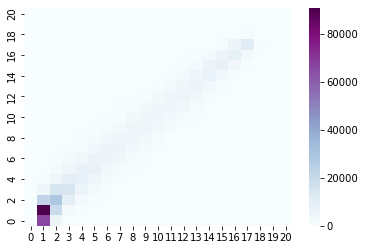

In [171]:
# Let's see the correlation between the two l2g scores:
ax = sns.heatmap(heatmap, cmap='BuPu')
ax.invert_yaxis()
plt.show()

In [177]:
jun_release = (
    spark.read.parquet('/Users/dsuveges/repositories/evidence_datasource_parsers/sourceId=ot_genetics_portal')
    .persist()
)

In [202]:
ids = [ "8749cf8b8049b5c057a8c0db94df6bbee2939aca",
  "3119b2d2014fbfd1fd01316d0f6142a3594c9016",
  "f14f8d90aadef3d3e2dac3e59e60041c16469ada",
  "ee02c534efbe62c375b20031731434b8e0ace6f5",
  "a6205a714fc214028da83d49844fa78b5d314747",
  "118b5399cf177fe3f561bfb2db923e74e9ed955a",
  "8933565c58a559211c7608c74cf637c86bf2b4eb",
  "faefe2b314e7ae8ff4826abf61c9de4769ff0a9b",
  "73abe7759dadbf364ebb1a36d24f1295aabdb14d",
  "8330242285263ad95f9d2ca6e17c6b2d003b6194",
  "704adc21a55ba19c6a0d8af5b9d57b383467f57e",
  "d05736f8a5e6c73a49544eef37232d266a8a5190",
  "023e38c23630993c7d9ca5311fb9069c848143e4",
  "5359d20098660e21c936eb570e960a30f3101014",
  "0e4c03b87eee7392b5d20af7671dfcf1ec23dc29",
  "f489cb20f9c14f7f5b0d20b2f4fe84b4894dae41",
  "9e8cd860b6710ed02b50d71bde225715d0d46b1a",
  "c0f01d3d181edea34a74767f7a2833b42417559a",
  "64315e283e863757f35bcaa1e2e3ec51bc31b14d",
  "27d8d81cf7f16df1d6ca8525da83dec4c4c08bad",
  "de8fa16235762bb19957235e0eb296cdd144e66e",
  "dd58a6c038759b4196ffe40b47434a8d83324986",
  "25846d4ca6372cd1498549cd96cb48cdfa4af9b2",
  "8733bf832613b264498592470ac77cfbccdb3ca4",
  "9fddd0b4fa7a95241ea84f6d6d27ff3d5679d17e",
  "c321785ac4230aadcc5439f1d7d5d1affb49a745",
  "878e886f968b7d7c3946145002756d64fefdd9fd",
  "1c2cdeb814d4718f7ee8dfad53cc6bbfa1d4421d",
  "4ce53dac2689a3e11f20994d6a7d38dbfa4061ca",
  "dc61c2d4c891321493d43fa63992d14688f17d06",
  "5542cb87d94c6133534796e972979d7711170495",
  "d94e15e1a7747fdd69ed54b8f0c048e50f32bf49",
  "edbef3a8cf9162d2739c8d389f42b30798fdec9d",
  "0c2f8bbfe09ffbbea25258d316ef28ef92da9504",
  "a87a986544353b7a8abf627f9eb093ee5c02ded3",
  "5f7e8dc3b35a8e9ba4bf28df1d86616f33a1990a",
  "5d299af185fb48c28b532bc936efbeedc114fc3e",
  "f3ccbfe053da4cb4c5a6c38d38d76aece8e35cf8",
  "5c517c7fa57c221a79af5059905ff7290c6d3dd2",
  "65864157682ae2df7673136b09d61eadfa166d72",
  "a3e36b23f2479a2e1f1b7278228a142b1c8079ff",
  "662a6f83168af6c808e39dfeed6ec1ca92af6fd7",
  "78383a3bf5aa9ccbfb1d99d1ba1afc3b78b1610c",
  "9076ad5d0d989bebd371ad392c0ecb51f4b2b6ff",
  "0c753eac81ebb247860c93955de8af8bf51195fb",
  "3e6be78f66551bb2179af90d0c9edb6dfa6bf14c",
  "54c41c981f9fe954e6fbb2a19b00b59b77ac845d",
  "97c658b4830646222e213c746581799223606a63",
  "cd3e04306925c354e42d529219c356804b80b779",
  "033d80b213fb837fb5025fca0d4065cab32823c8",
  "b641de83f54a7134500a5cbd1bd26f79d2e63199",
  "2d81614d2e2d78b9b9c8a0c9a5f9eb74ce0c94bf",
  "f8bdd5f466b460fe785d178020c52e8d200bf10c",
  "d1b80add9cafbdd0d34981b6de9f232686a984cc",
  "7330e3105c2632d3ed08932b9f5671e502de83ec",
  "a0a3938eee60fc87c7770e6cab9ae357833390ee",
  "5413f7095fe837be5d2bb7bef3943825ab80f9e5",
  "b5c8e8e267268237da85c495818b1615dfeb1dd8"]

problematic_row = (
    jun_release
    .filter(col('id').isin(ids))
    .select(
        col('targetId').alias('target'), 
        col('diseaseFromSourceMappedId').alias('disease'),
        col('oddsRatio').alias('OR'),
        col('oddsRatioConfidenceIntervalLower').alias('OR_low'),
        col('oddsRatioConfidenceIntervalUpper').alias('OR_up'),
        col('beta').alias('beta'),
        col('betaConfidenceIntervalLower').alias('beta_low'),
        col('betaConfidenceIntervalUpper').alias('beta_up'),
        col('pValueExponent').alias('pv_exp'),
        col('pValueMantissa').alias('pv_mantissa')
    )
    .persist()
#     .show(100, truncate=False)
)

In [203]:
(
    problematic_row
    .filter(col('OR_up') == spark_max(col('OR_up')))
    .show()
)

AnalysisException: 
Aggregate/Window/Generate expressions are not valid in where clause of the query.
Expression in where clause: [(`OR_up` = max(`OR_up`))]
Invalid expressions: [max(`OR_up`)];
Filter (OR_up#37759 = max(OR_up#37759))
+- Project [targetId#18361 AS target#37755, diseaseFromSourceMappedId#18384 AS disease#37756, oddsRatio#18392 AS OR#37757, oddsRatioConfidenceIntervalLower#18393 AS OR_low#37758, oddsRatioConfidenceIntervalUpper#18394 AS OR_up#37759, beta#18364 AS beta#37760, betaConfidenceIntervalLower#18365 AS beta_low#37761, betaConfidenceIntervalUpper#18366 AS beta_up#37762, pValueExponent#18395L AS pv_exp#37763L, pValueMantissa#18396 AS pv_mantissa#37764]
   +- Filter id#18424 IN (8749cf8b8049b5c057a8c0db94df6bbee2939aca,3119b2d2014fbfd1fd01316d0f6142a3594c9016,f14f8d90aadef3d3e2dac3e59e60041c16469ada,ee02c534efbe62c375b20031731434b8e0ace6f5,a6205a714fc214028da83d49844fa78b5d314747,118b5399cf177fe3f561bfb2db923e74e9ed955a,8933565c58a559211c7608c74cf637c86bf2b4eb,faefe2b314e7ae8ff4826abf61c9de4769ff0a9b,73abe7759dadbf364ebb1a36d24f1295aabdb14d,8330242285263ad95f9d2ca6e17c6b2d003b6194,704adc21a55ba19c6a0d8af5b9d57b383467f57e,d05736f8a5e6c73a49544eef37232d266a8a5190,023e38c23630993c7d9ca5311fb9069c848143e4,5359d20098660e21c936eb570e960a30f3101014,0e4c03b87eee7392b5d20af7671dfcf1ec23dc29,f489cb20f9c14f7f5b0d20b2f4fe84b4894dae41,9e8cd860b6710ed02b50d71bde225715d0d46b1a,c0f01d3d181edea34a74767f7a2833b42417559a,64315e283e863757f35bcaa1e2e3ec51bc31b14d,27d8d81cf7f16df1d6ca8525da83dec4c4c08bad,de8fa16235762bb19957235e0eb296cdd144e66e,dd58a6c038759b4196ffe40b47434a8d83324986,25846d4ca6372cd1498549cd96cb48cdfa4af9b2,8733bf832613b264498592470ac77cfbccdb3ca4,9fddd0b4fa7a95241ea84f6d6d27ff3d5679d17e,c321785ac4230aadcc5439f1d7d5d1affb49a745,878e886f968b7d7c3946145002756d64fefdd9fd,1c2cdeb814d4718f7ee8dfad53cc6bbfa1d4421d,4ce53dac2689a3e11f20994d6a7d38dbfa4061ca,dc61c2d4c891321493d43fa63992d14688f17d06,5542cb87d94c6133534796e972979d7711170495,d94e15e1a7747fdd69ed54b8f0c048e50f32bf49,edbef3a8cf9162d2739c8d389f42b30798fdec9d,0c2f8bbfe09ffbbea25258d316ef28ef92da9504,a87a986544353b7a8abf627f9eb093ee5c02ded3,5f7e8dc3b35a8e9ba4bf28df1d86616f33a1990a,5d299af185fb48c28b532bc936efbeedc114fc3e,f3ccbfe053da4cb4c5a6c38d38d76aece8e35cf8,5c517c7fa57c221a79af5059905ff7290c6d3dd2,65864157682ae2df7673136b09d61eadfa166d72,a3e36b23f2479a2e1f1b7278228a142b1c8079ff,662a6f83168af6c808e39dfeed6ec1ca92af6fd7,78383a3bf5aa9ccbfb1d99d1ba1afc3b78b1610c,9076ad5d0d989bebd371ad392c0ecb51f4b2b6ff,0c753eac81ebb247860c93955de8af8bf51195fb,3e6be78f66551bb2179af90d0c9edb6dfa6bf14c,54c41c981f9fe954e6fbb2a19b00b59b77ac845d,97c658b4830646222e213c746581799223606a63,cd3e04306925c354e42d529219c356804b80b779,033d80b213fb837fb5025fca0d4065cab32823c8,b641de83f54a7134500a5cbd1bd26f79d2e63199,2d81614d2e2d78b9b9c8a0c9a5f9eb74ce0c94bf,f8bdd5f466b460fe785d178020c52e8d200bf10c,d1b80add9cafbdd0d34981b6de9f232686a984cc,7330e3105c2632d3ed08932b9f5671e502de83ec,a0a3938eee60fc87c7770e6cab9ae357833390ee,5413f7095fe837be5d2bb7bef3943825ab80f9e5,b5c8e8e267268237da85c495818b1615dfeb1dd8)
      +- Relation[datasourceId#18360,targetId#18361,alleleOrigins#18362,allelicRequirements#18363,beta#18364,betaConfidenceIntervalLower#18365,betaConfidenceIntervalUpper#18366,biologicalModelAllelicComposition#18367,biologicalModelGeneticBackground#18368,biologicalModelId#18369,biosamplesFromSource#18370,clinicalPhase#18371L,clinicalSignificances#18372,clinicalStatus#18373,cohortDescription#18374,cohortId#18375,cohortPhenotypes#18376,cohortShortName#18377,confidence#18378,contrast#18379,datatypeId#18380,diseaseCellLines#18381,diseaseFromSource#18382,diseaseFromSourceId#18383,... 42 more fields] parquet


In [184]:
n, p = 2, 1/3


0.4444444444444444

In [193]:
from scipy.stats import binom
max_dobas = 10
[', '.join([str(round(binom.pmf(k, n, p), 3)) for k in range(n+1)]) for n in range(1,max_dobas + 1)]

['0.667, 0.333',
 '0.444, 0.444, 0.111',
 '0.296, 0.444, 0.222, 0.037',
 '0.198, 0.395, 0.296, 0.099, 0.012',
 '0.132, 0.329, 0.329, 0.165, 0.041, 0.004',
 '0.088, 0.263, 0.329, 0.219, 0.082, 0.016, 0.001',
 '0.059, 0.205, 0.307, 0.256, 0.128, 0.038, 0.006, 0.0',
 '0.039, 0.156, 0.273, 0.273, 0.171, 0.068, 0.017, 0.002, 0.0',
 '0.026, 0.117, 0.234, 0.273, 0.205, 0.102, 0.034, 0.007, 0.001, 0.0',
 '0.017, 0.087, 0.195, 0.26, 0.228, 0.137, 0.057, 0.016, 0.003, 0.0, 0.0']

In [195]:
print("\n".join([', '.join([str(round(binom.pmf(k, n, p), 3)) for k in range(n+1)]) for n in range(1,max_dobas + 1)]))

0.667, 0.333
0.444, 0.444, 0.111
0.296, 0.444, 0.222, 0.037
0.198, 0.395, 0.296, 0.099, 0.012
0.132, 0.329, 0.329, 0.165, 0.041, 0.004
0.088, 0.263, 0.329, 0.219, 0.082, 0.016, 0.001
0.059, 0.205, 0.307, 0.256, 0.128, 0.038, 0.006, 0.0
0.039, 0.156, 0.273, 0.273, 0.171, 0.068, 0.017, 0.002, 0.0
0.026, 0.117, 0.234, 0.273, 0.205, 0.102, 0.034, 0.007, 0.001, 0.0
0.017, 0.087, 0.195, 0.26, 0.228, 0.137, 0.057, 0.016, 0.003, 0.0, 0.0


In [199]:
a=[342, 763, 927]

[int(str(x)[::-1]) for x in a]

[243, 367, 729]